# Imports

In [1]:
import os

import numpy as np
import pandas as pd

In [2]:
import seaborn as sns
from matplotlib import pyplot as plt


sns.set(rc={"figure.dpi": 100, "savefig.dpi": 300})
sns.set_context("notebook")
sns.set_style("ticks")

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
SEED = 42

# Paths

Here we set a relative path so that we can easily export this notebook from Kaggle, change the path and run it locally.

In [6]:
RELATIVE_PATH = "../data"

# Evaluation Metric

In this competition we are going to use Root Mean Squared Error (`RMSE`). 

RMSE is defined as:  
$\textrm{RMSE} =  \sqrt{ \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2 }$,  

where (for each instance $i$):
- $\hat{y}_i$ is the predicted value
- $y_i$ is the original value.

# Data

The dataset for this competition (both `train` and `test`) was generated from a deep learning model trained on the *California Housing Dataset*.  
Feature distributions are close to, but not exactly the same, as the original.  

We can use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.  

In this version, we'll be focusing on the original dataset.

## Loading the data

In [7]:
data = pd.read_csv(os.path.join(RELATIVE_PATH, "train.csv"))
test = pd.read_csv(os.path.join(RELATIVE_PATH, "test.csv"))

## Setting the columns

This dataset contains only numerical columns, which are listed below:

In [8]:
num_cols = [
    "MedInc",
    "HouseAge",
    "AveRooms",
    "AveBedrms",
    "Population",
    "AveOccup",
    "Latitude",
    "Longitude",
]
cat_cols = []

feature_cols = num_cols + cat_cols
target_col = "MedHouseVal"

## Dataset Overview

This can be done using the `df.sample(n=10, random_state=SEED)` method, specifying the number of lines `n` and `random_state` (for reproducible calculations).  

I looked at 30 random lines, but left 10 in the code for easier viewing. Missing values are not visually visible - we will check this formally in the next section.
You can also look at the beginning and end of the dataset using the `df.head(n=10)` and `df.tail(n=10)` methods, respectively.

In [9]:
data.sample(n=10, random_state=SEED)

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
31089,31089,5.0855,17.0,6.190805,1.105747,1538.0,3.373563,38.02,-121.36,1.035
28863,28863,3.3636,5.0,4.239899,1.020202,3278.0,2.066007,33.68,-117.53,1.969
20379,20379,5.0417,29.0,6.602317,1.023529,1119.0,2.705479,33.84,-117.95,2.638
3942,3942,4.1364,22.0,5.448584,0.986717,1750.0,3.020478,38.47,-121.77,1.188
26360,26360,1.6031,39.0,4.742204,1.075092,1168.0,3.250000,36.75,-119.80,0.669
13295,13295,3.0278,25.0,3.614170,1.077714,842.0,1.392324,36.63,-121.91,2.256
14971,14971,1.9875,25.0,4.285714,1.090774,569.0,1.661905,38.57,-121.46,1.094
27775,27775,5.0965,9.0,6.184426,1.004425,2140.0,3.707572,37.72,-121.44,1.654
14206,14206,2.3750,7.0,4.906195,1.173784,1391.0,1.741803,32.85,-117.22,1.777
465,465,2.7979,40.0,3.881874,1.176935,784.0,2.114174,37.74,-122.45,3.750


## Dataset Close Look

In this section, let's look at what columns we have, what type they are, how many non-zero values, etc.

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37137 entries, 0 to 37136
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           37137 non-null  int64  
 1   MedInc       37137 non-null  float64
 2   HouseAge     37137 non-null  float64
 3   AveRooms     37137 non-null  float64
 4   AveBedrms    37137 non-null  float64
 5   Population   37137 non-null  float64
 6   AveOccup     37137 non-null  float64
 7   Latitude     37137 non-null  float64
 8   Longitude    37137 non-null  float64
 9   MedHouseVal  37137 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 2.8 MB


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24759 entries, 0 to 24758
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          24759 non-null  int64  
 1   MedInc      24759 non-null  float64
 2   HouseAge    24759 non-null  float64
 3   AveRooms    24759 non-null  float64
 4   AveBedrms   24759 non-null  float64
 5   Population  24759 non-null  float64
 6   AveOccup    24759 non-null  float64
 7   Latitude    24759 non-null  float64
 8   Longitude   24759 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 1.7 MB


In total, we have 37137 lines in the sample for training. In the test sample we have 24759 objects. 

There are no missing values. Let's confirm this again.

This can be done with the `.isna()` or `.isnull()` methods - as far as I understand they are equivalent:
- `data.isnull()` gives True for each value if it is omitted and False otherwise.
- `data.isnull().any()` shows whether there are missing values in columns (aggregated).
- `data.isnull().values.any()` generalizes missing value resolution to the entire dataset.

In [12]:
assert data.isnull().values.any() == False

# Exploratory Data Analysis

## Numerical features

We can easily reuse this code to compare distributions of the features with original dataset.

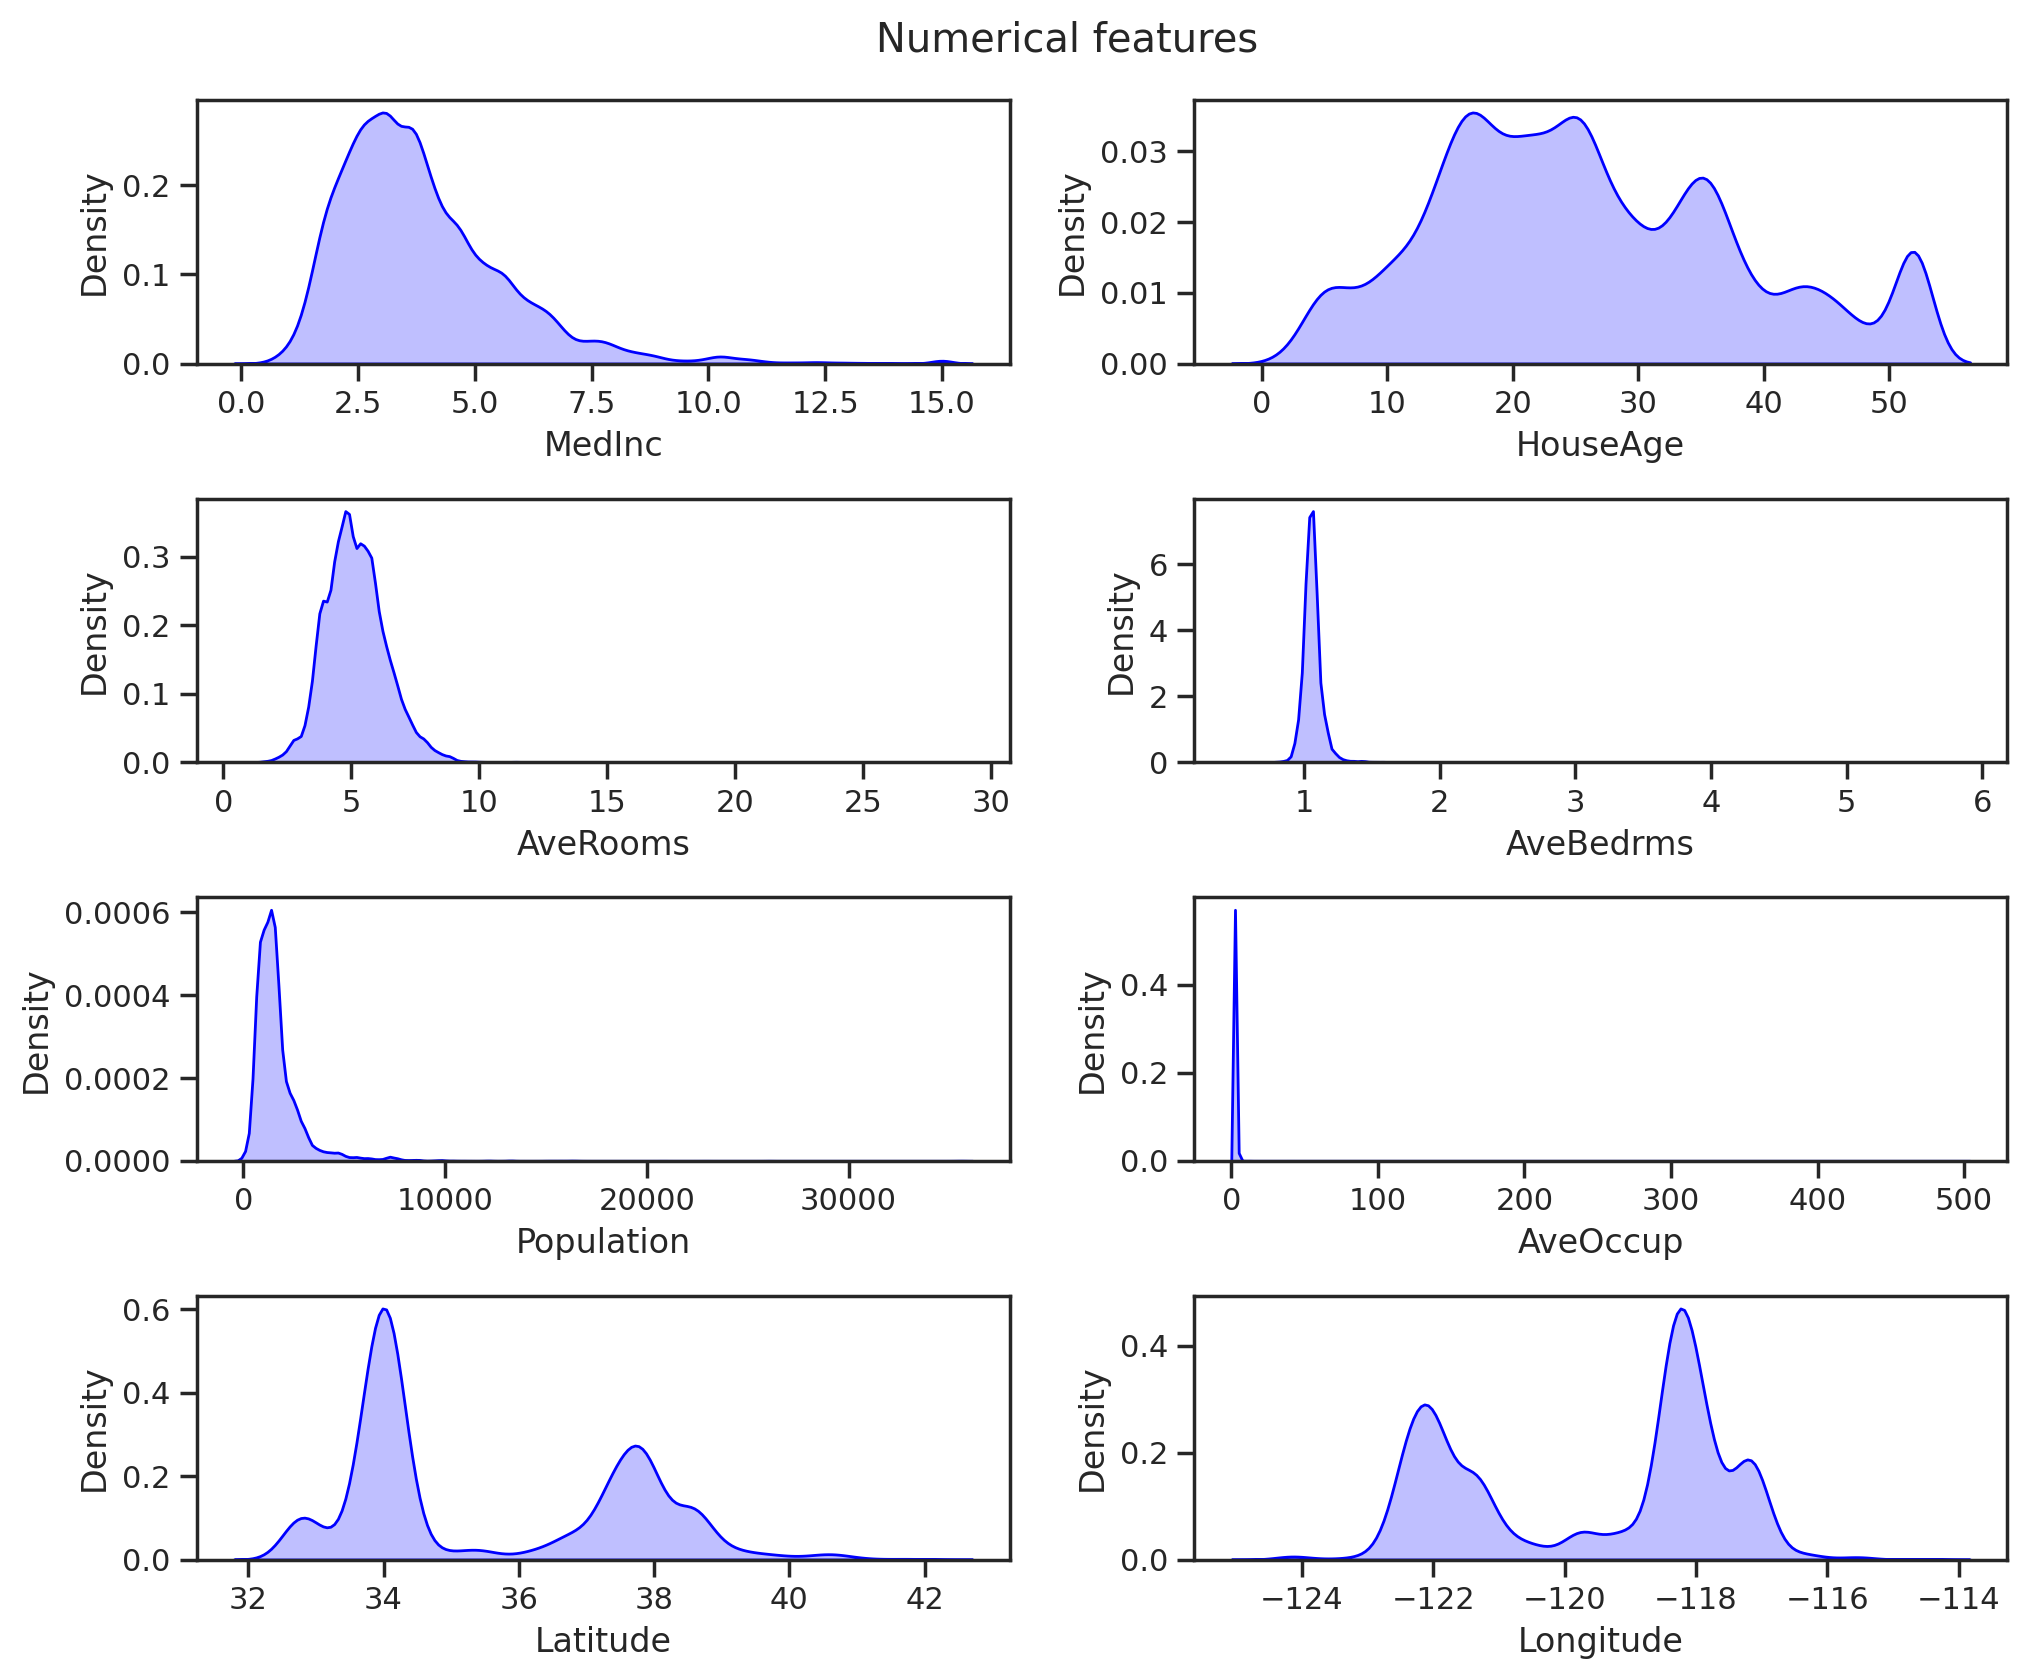

In [13]:
fig, axs = plt.subplots(nrows=len(num_cols) // 2, ncols=2, figsize=(10, 8))
axs = axs.ravel()
fig.tight_layout(h_pad=2, w_pad=2)

for i, num_feature in enumerate(num_cols):
    g1 = sns.kdeplot(data=data, x=num_feature, ax=axs[i], color="blue", fill=True)

fig.suptitle("Numerical features", y=1.02);

As an analogue of the histogram, you can use the [KDE graph](https://en.wikipedia.org/wiki/Kernel_density_estimation) - it makes it easier to visualize and interpret the data.

We have 8 numeric features:
- `MedInc` median income in block group
- `HouseAge` median house age in block group
- `AveRooms` average number of rooms per household
- `AveBedrms` average number of bedrooms per household
- `Population` block group population
- `AveOccup` average number of household members
- `Latitude` block group latitude
- `Longitude` block group longitude

More information about the original dataset can be found [here](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset).

## Target variable

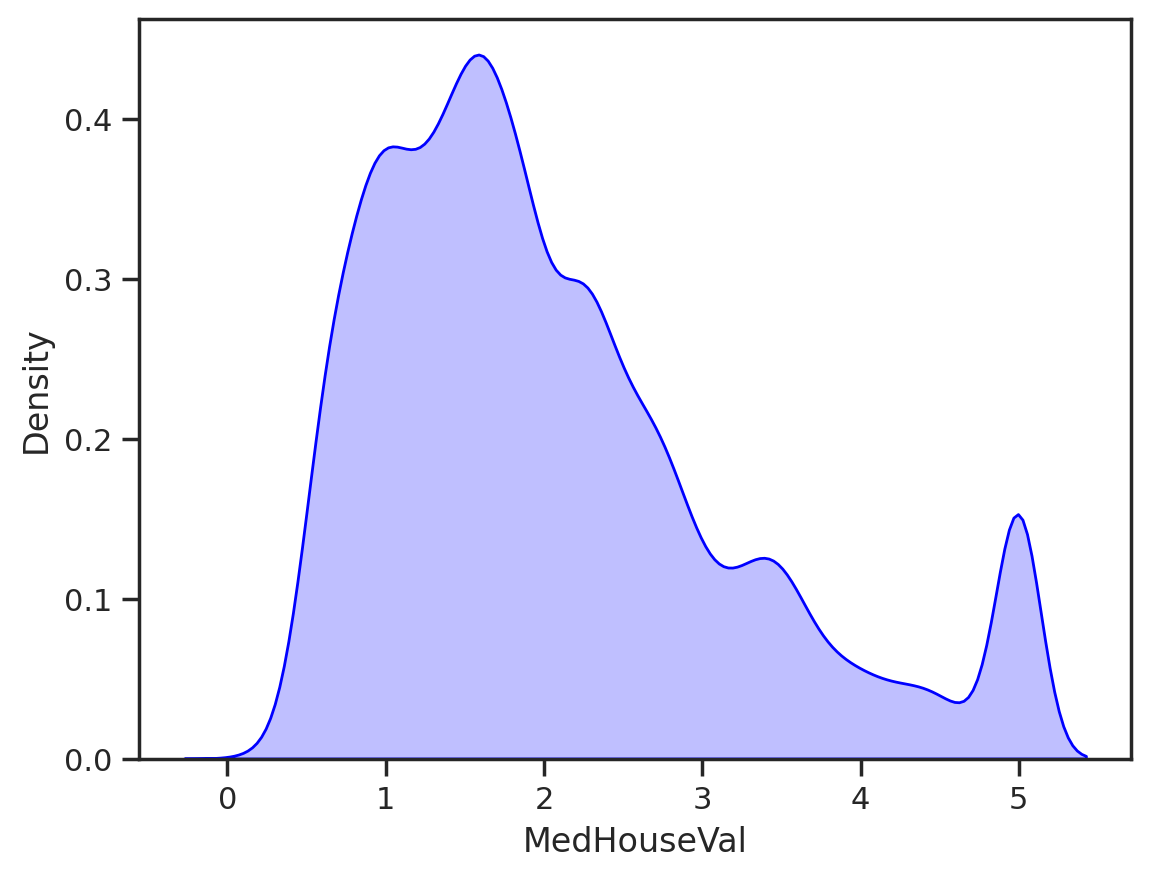

In [14]:
sns.kdeplot(data=data, x=target_col, color="blue", fill=True);

The target variable (`MedHouseVal`) is the median house value for California districts, expressed in hundreds of thousands of dollars ($100,000).

## Duplicates

In [15]:
assert data.shape == data.drop_duplicates().shape

We don't have duplicates.